In [1]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

# Path to the GTZAN dataset
dataset_path = r'F:/university/milan/third semester/audio pattern/final/datasets/Data'

# Explore the dataset structure
for genre in os.listdir(dataset_path):
    genre_path = os.path.join(dataset_path, genre)
    if os.path.isdir(genre_path):
        print(f"Genre: {genre}")
        files = os.listdir(genre_path)
        print(f"Number of tracks: {len(files)}")
        print(f"Sample files: {files[:5]}")


Genre: genres_original
Number of tracks: 10
Sample files: ['blues', 'classical', 'country', 'disco', 'hiphop']
Genre: images_original
Number of tracks: 10
Sample files: ['blues', 'classical', 'country', 'disco', 'hiphop']


In [3]:
# Function to set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch (CPU)
    torch.cuda.manual_seed(seed)  # PyTorch (GPU)
    torch.cuda.manual_seed_all(seed)  # All GPU devices
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable automatic optimization for convolution algorithms

# Seed worker function for data loading
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % (2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set random seeds
set_seed(42)

# Load CSV data
data_path = 'F:/university/milan/third semester/audio pattern/final/datasets/Data/features_3_sec.csv'
df = pd.read_csv(data_path)

# Preprocess the features
X = np.array(df.drop(['filename', 'label'], axis=1))  # Drop non-feature columns
y = np.array(df['label'].values)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=39, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified Shuffle Split for train, validation, and test
# Step 1: Stratified Shuffle Split for initial train and test split
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(ss_split.split(X_pca, y_encoded))

# Step 2: Further split the train set into train and validation sets
# 80% training and 20% validation
train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=42)

# Extracting the data
X_train, X_test, y_train, y_test = X_pca[train_indices], X_pca[test_indices], y_encoded[train_indices], y_encoded[test_indices]
X_val, y_val = X_pca[val_indices], y_encoded[val_indices]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataset class
class MusicGenreDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# DataLoader for batching
train_dataset = MusicGenreDataset(X_train_tensor, y_train_tensor)
val_dataset = MusicGenreDataset(X_val_tensor, y_val_tensor)
test_dataset = MusicGenreDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=seed_worker)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, worker_init_fn=seed_worker)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, worker_init_fn=seed_worker)

## FCNN

In [4]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 128)  # Start with a smaller number of neurons
        self.fc2 = nn.Linear(128, 256)  # Increase the number of neurons
        self.fc3 = nn.Linear(256, 512)  # Further increase to capture more complex patterns
        self.fc4 = nn.Linear(512, 256)  # Start reducing the number of neurons
        self.fc5 = nn.Linear(256, 128)  # Further reduce the number of neurons
        self.fc6 = nn.Linear(128, 10)  # Output layer with 10 genres
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.fc6(x)  # Final output layer
        return x

Epoch 1/150, Train Loss: 2.0773, Val Loss: 1.5759
Epoch 2/150, Train Loss: 1.4827, Val Loss: 1.3349
Epoch 3/150, Train Loss: 1.3541, Val Loss: 1.2768
Epoch 4/150, Train Loss: 1.2952, Val Loss: 1.1832
Epoch 5/150, Train Loss: 1.2151, Val Loss: 1.1476
Epoch 6/150, Train Loss: 1.1634, Val Loss: 1.0776
Epoch 7/150, Train Loss: 1.1037, Val Loss: 1.0622
Epoch 8/150, Train Loss: 1.0617, Val Loss: 1.0055
Epoch 9/150, Train Loss: 1.0357, Val Loss: 0.9777
Epoch 10/150, Train Loss: 1.0089, Val Loss: 0.9638
Epoch 11/150, Train Loss: 0.9816, Val Loss: 0.9269
Epoch 12/150, Train Loss: 0.9670, Val Loss: 0.9110
Epoch 13/150, Train Loss: 0.9342, Val Loss: 0.9191
Epoch 14/150, Train Loss: 0.9139, Val Loss: 0.8856
Epoch 15/150, Train Loss: 0.9032, Val Loss: 0.8639
Epoch 16/150, Train Loss: 0.8877, Val Loss: 0.8461
Epoch 17/150, Train Loss: 0.8500, Val Loss: 0.8286
Epoch 18/150, Train Loss: 0.8521, Val Loss: 0.8191
Epoch 19/150, Train Loss: 0.8408, Val Loss: 0.8085
Epoch 20/150, Train Loss: 0.8121, Val Lo

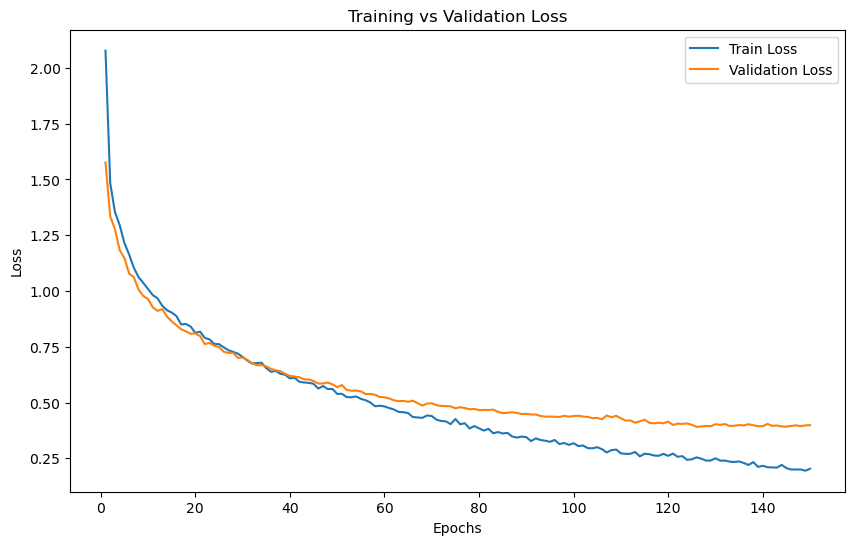

Tuned Classification Report:
              precision    recall  f1-score   support

       blues       0.86      0.89      0.87       200
   classical       0.91      0.94      0.93       199
     country       0.74      0.86      0.80       199
       disco       0.85      0.85      0.85       200
      hiphop       0.91      0.88      0.89       200
        jazz       0.88      0.82      0.85       200
       metal       0.93      0.94      0.93       200
         pop       0.90      0.84      0.87       200
      reggae       0.85      0.87      0.86       200
        rock       0.87      0.78      0.82       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998



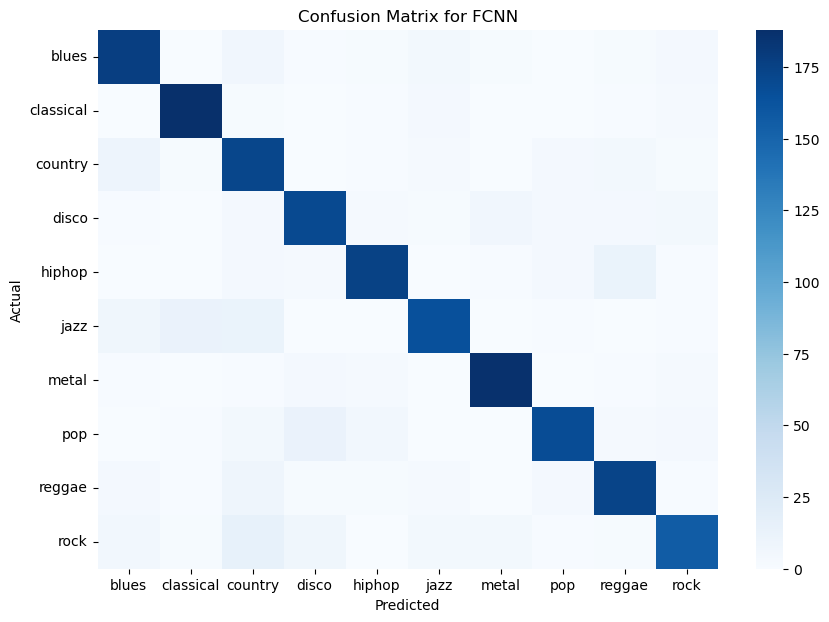

In [5]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Plotting losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()

    return model

# Evaluate Model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
    
    # Classification Report for the tuned model
    class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    print("Tuned Classification Report:")
    print(class_report)

    # Confusion Matrix heatmap
    plt.figure(figsize=(10, 7))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot= False, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix for FCNN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Initialize model, criterion, and optimizer
model = FullyConnectedNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=150)

# Evaluate the model
evaluate_model(trained_model, test_loader)

In [8]:
# Apply PCA for dimensionality reduction (reduce to 40 components)
pca = PCA(n_components=40)
X_pca = pca.fit_transform(X_scaled)

# Encode the labels (genres)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Reshaping X_pca to have a sequence dimension (e.g., treating each sample as a sequence of time steps)
num_time_steps = 5  # You can adjust this based on how you want to treat your features as time steps
num_features = X_pca.shape[1] // num_time_steps

# Reshape the data to fit the LSTM input shape
X_pca_seq = X_pca.reshape((X_pca.shape[0], num_time_steps, num_features))

# Split data into training, validation, and testing
X_train, X_temp, y_train, y_temp = train_test_split(X_pca_seq, y_encoded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a Dataset class
class MusicGenreDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# DataLoader for batching
train_dataset = MusicGenreDataset(X_train_tensor, y_train_tensor)
val_dataset = MusicGenreDataset(X_val_tensor, y_val_tensor)
test_dataset = MusicGenreDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Epoch 1/80, Train Loss: 2.2287, Validation Loss: 1.8961
Epoch 2/80, Train Loss: 1.7080, Validation Loss: 1.5585
Epoch 3/80, Train Loss: 1.5578, Validation Loss: 1.4825
Epoch 4/80, Train Loss: 1.4830, Validation Loss: 1.4163
Epoch 5/80, Train Loss: 1.4210, Validation Loss: 1.3656
Epoch 6/80, Train Loss: 1.3678, Validation Loss: 1.3204
Epoch 7/80, Train Loss: 1.3374, Validation Loss: 1.3096
Epoch 8/80, Train Loss: 1.3030, Validation Loss: 1.2668
Epoch 9/80, Train Loss: 1.2736, Validation Loss: 1.2461
Epoch 10/80, Train Loss: 1.2465, Validation Loss: 1.2237
Epoch 11/80, Train Loss: 1.2249, Validation Loss: 1.2092
Epoch 12/80, Train Loss: 1.1992, Validation Loss: 1.1898
Epoch 13/80, Train Loss: 1.1709, Validation Loss: 1.1606
Epoch 14/80, Train Loss: 1.1567, Validation Loss: 1.1407
Epoch 15/80, Train Loss: 1.1459, Validation Loss: 1.1338
Epoch 16/80, Train Loss: 1.1153, Validation Loss: 1.1134
Epoch 17/80, Train Loss: 1.1015, Validation Loss: 1.1020
Epoch 18/80, Train Loss: 1.0857, Validat

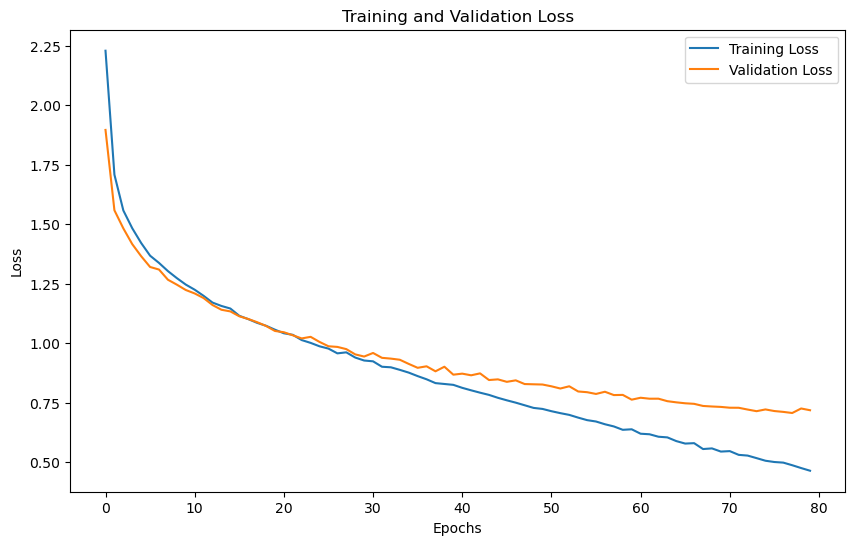

Tuned Classification Report:
              precision    recall  f1-score   support

       blues       0.75      0.88      0.81        98
   classical       0.95      0.93      0.94       108
     country       0.69      0.78      0.73        96
       disco       0.73      0.71      0.72        99
      hiphop       0.82      0.77      0.79       107
        jazz       0.81      0.82      0.81        94
       metal       0.87      0.87      0.87       105
         pop       0.95      0.87      0.91        92
      reggae       0.83      0.76      0.79       104
        rock       0.69      0.69      0.69        96

    accuracy                           0.81       999
   macro avg       0.81      0.81      0.81       999
weighted avg       0.81      0.81      0.81       999



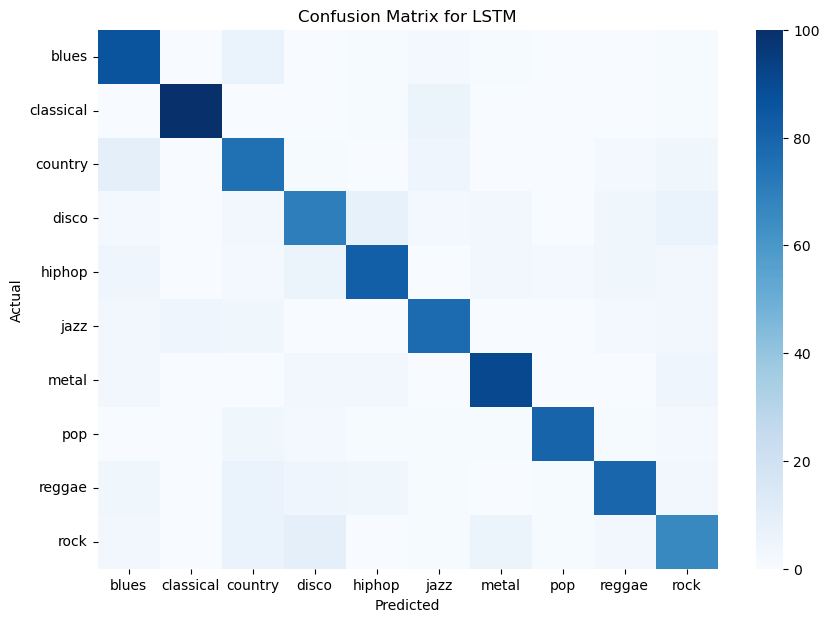

In [9]:

# LSTM Model for Genre Recognition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, dropout=0.3, bidirectional=True):
        super(LSTMModel, self).__init__()
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout, 
            bidirectional=bidirectional
        )
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc1 = nn.Linear(lstm_output_size, lstm_output_size // 2)  # Reduce dimensionality
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(lstm_output_size // 2, num_classes)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final_hidden_state = lstm_out[:, -1, :]  # Use last time step
        x = self.fc1(final_hidden_state)
        x = self.relu(x)
        x = self.dropout(x)
        output = self.fc2(x)
        return output


# Initialize the model
input_size = num_features  # Number of features per time step
hidden_size = 128  # Number of LSTM units
num_classes = len(np.unique(y_encoded))  # Number of genres
model = LSTMModel(input_size, hidden_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop with Validation
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        train_losses.append(running_train_loss / len(train_loader))
        val_losses.append(running_val_loss / len(val_loader))
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_train_loss / len(train_loader):.4f}, Validation Loss: {running_val_loss / len(val_loader):.4f}")
    
    return train_losses, val_losses

# Train the model with validation loss tracking
train_losses, val_losses = train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, num_epochs=80)

# Plotting the Training and Validation Losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
    
    # Classification Report for the tuned model
    class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    print("Tuned Classification Report:")
    print(class_report)

    # Confusion Matrix heatmap
    plt.figure(figsize=(10, 7))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot= False, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix for LSTM')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate the model
evaluate_model(model, test_loader)


## improved cnn

In [6]:
# Improved CNN Model
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        
        # Input Layer
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 128)  # Smaller initial layer
        self.bn1 = nn.BatchNorm1d(128)
        
        # First hidden layer
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        
        # Second hidden layer
        self.fc3 = nn.Linear(256, 512)
        self.bn3 = nn.BatchNorm1d(512)
        
        # Third hidden layer
        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        
        # Final hidden layer
        self.fc5 = nn.Linear(1024, 512)
        self.bn5 = nn.BatchNorm1d(512)
        
        # Output layer
        self.fc6 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        
        x = self.fc6(x)  # Final output layer
        return x

Epoch 1/250, Train Loss: 1.7355, Val Loss: 1.3318
Epoch 2/250, Train Loss: 1.3801, Val Loss: 1.1378
Epoch 3/250, Train Loss: 1.2684, Val Loss: 1.0341
Epoch 4/250, Train Loss: 1.1693, Val Loss: 0.9770
Epoch 5/250, Train Loss: 1.1250, Val Loss: 0.9184
Epoch 6/250, Train Loss: 1.0789, Val Loss: 0.8941
Epoch 7/250, Train Loss: 1.0513, Val Loss: 0.8441
Epoch 8/250, Train Loss: 1.0174, Val Loss: 0.8160
Epoch 9/250, Train Loss: 0.9829, Val Loss: 0.7704
Epoch 10/250, Train Loss: 0.9598, Val Loss: 0.7561
Epoch 11/250, Train Loss: 0.9389, Val Loss: 0.7084
Epoch 12/250, Train Loss: 0.8999, Val Loss: 0.7075
Epoch 13/250, Train Loss: 0.8824, Val Loss: 0.6863
Epoch 14/250, Train Loss: 0.8735, Val Loss: 0.6857
Epoch 15/250, Train Loss: 0.8590, Val Loss: 0.6620
Epoch 16/250, Train Loss: 0.8370, Val Loss: 0.6526
Epoch 17/250, Train Loss: 0.8358, Val Loss: 0.6344
Epoch 18/250, Train Loss: 0.7957, Val Loss: 0.6274
Epoch 19/250, Train Loss: 0.7779, Val Loss: 0.5999
Epoch 20/250, Train Loss: 0.7728, Val Lo

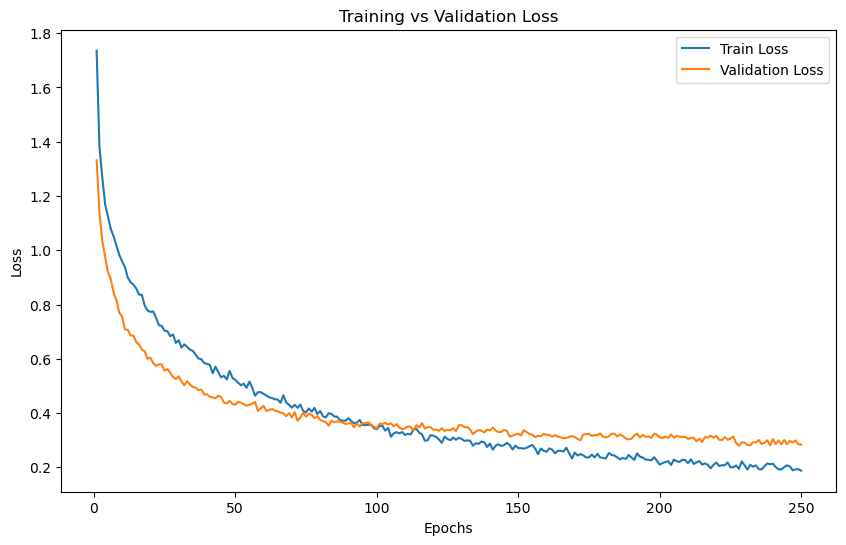

Tuned Classification Report:
              precision    recall  f1-score   support

       blues       0.95      0.93      0.94       200
   classical       0.90      0.96      0.93       199
     country       0.82      0.89      0.86       199
       disco       0.86      0.91      0.89       200
      hiphop       0.92      0.93      0.92       200
        jazz       0.93      0.87      0.90       200
       metal       0.96      0.93      0.94       200
         pop       0.96      0.88      0.92       200
      reggae       0.91      0.90      0.90       200
        rock       0.86      0.88      0.87       200

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



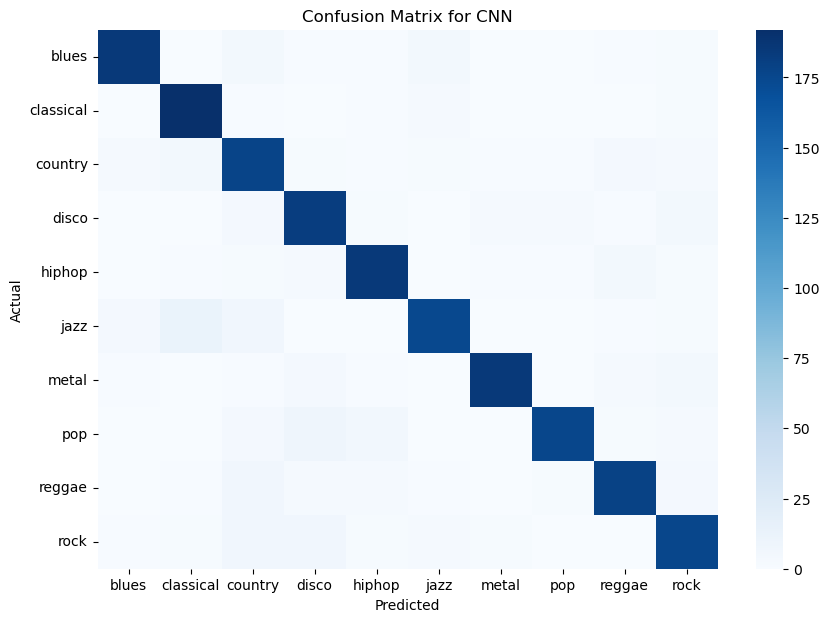

In [7]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Plotting losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()

    return model

# Evaluate Model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
    
    # Classification Report for the tuned model
    class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    print("Tuned Classification Report:")
    print(class_report)

    # Confusion Matrix heatmap
    plt.figure(figsize=(10, 7))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot= False, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix for CNN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Initialize model, criterion, and optimizer
model = ImprovedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=250)

# Evaluate the model
evaluate_model(trained_model, test_loader)
